All the functions we will use are in the file FeatureExtraction.py, which we import here.

In [1]:
run FeatureExtraction.py

We also import a library for displaying images, and another for manifold learning.

In [2]:
from IPython.display import Image, display


import sklearn.cluster as cl
from sklearn.manifold import Isomap

In [26]:
import warnings
warnings.filterwarnings("ignore")

We can write a file with a random sample of taps using this code:

In [5]:
users = 3 #Sample size
sessions_for_each = 3
directory = 'NewData'
file_name = 'RandomSample6.csv'

make_directory(directory)

# user_sample = random.sample(get_user_ids(), users)
# for user_id in user_sample:
#     print(user_id)
#     frames = []
#     for session in random.sample(get_user_session_ids(user_id), sessions_for_each):
#         print(session)
#         try:
#             frames.append(get_feature_vector(user_id, session))
#         except:
#             print("Error in session " + session)
#             continue
#     features = pd.concat(frames, ignore_index = True)
#     features.to_csv(directory + '/Sample' + user_id, header = True, index = False)

listOfFiles = os.listdir(directory)
listOfFiles = list(filter(lambda x: x[0:6] == 'Sample', listOfFiles))
user_sample = list(map(lambda x: x[6:], listOfFiles))


user_data = [pd.read_csv(directory + '/Sample' + user_id, header=0, index_col=False) for user_id in user_sample]
aggregate_data = pd.concat(user_data, ignore_index = True)
aggregate_data.to_csv(directory + '/' + file_name, header = True, index = False)


We will use this code to do manifold learning on a set of data:

In [18]:
# Let's retrieve the file from the last session
directory = 'NewData'
file_name = 'RandomSample6.csv'
data = pd.read_csv(directory + '/' + file_name, header=0, index_col=False)

#Restricting our attention to OneFingerTouch and KeyPress sometimes helps
#data = data[(data.TapType == 'KeyPress')] # | (data.TapType == 'OneFingerTouch')]

count_matrix = data.UserID.value_counts()
users = count_matrix.index
counts = [count_matrix[u] for u in users]
bad_users = []
for i in range(len(counts)):
    if counts[i] < 100:
        bad_users.append(users[i])
        
for b in bad_users:
    data = data[data.UserID != b]

# Natural log some of them columns
for file_name in file_names:
    for y in y_columns[file_name]:
        for suffix in ['_restoration_time', '_normalized_duration', '_normalized_duration_max']:
            data[y + suffix] = log_column(data, y + suffix)

data = data.dropna()

numeric_data = data[get_numerical_feature_names()]


isomap = Isomap(n_neighbors=5, n_components=3)
isomap.fit(numeric_data)


manifold_3Da = isomap.transform(numeric_data)
manifold_3D = pd.DataFrame(manifold_3Da, columns=['Comp1', 'Comp2', 'Comp3'])
manifold_3D['TapType'] = pd.factorize(data['TapType'])[0]
manifold_3D['TaskName'] = pd.factorize(data['TaskName'])[0]
manifold_3D['UserID'] = pd.factorize(data['UserID'])[0]

1


Now we plot:

In [19]:
kmeans = cl.KMeans(n_clusters=3).fit(manifold_3D)
manifold_3D['Label'] = kmeans.labels_

In [21]:
def plot_manifold(data: DataFrame, color = None):
    """
    Assume data has the correct columns
    """
    x, y, z = [data[column_name] for column_name in ['Comp1', 'Comp2', 'Comp3']]
    ax = plt.figure().gca(projection='3d')
    if color != None:
        ax.scatter(x, y, z, c=data[color])
        plt.title('Color determined by ' + color)
    else:
        ax.scatter(x, y, z)
    plt.show()
    plt.close()

In [90]:
def all_possible_sublists(elements, length):
    """
    All possible sublists of elements having the specified length and preserving order.
    This should really use dynamic programming, but it uses recursion instead, so don't
    run it on large lists with large values of length
    """
    if length == 0:
        return [[]]
    sublists = []
    for i in range(len(elements)):
        remaining_elements = elements[i+1:]
        smaller_lists = all_possible_sublists(remaining_elements, length - 1)
        append_to_start = lambda x: [elements[i]] + x
        sublists += list(map(append_to_start, smaller_lists))
    return sublists

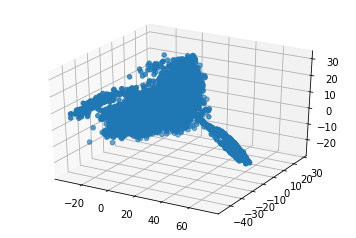

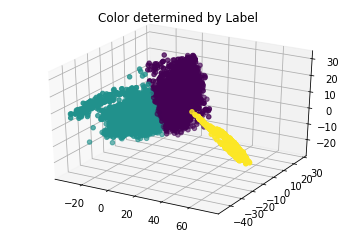

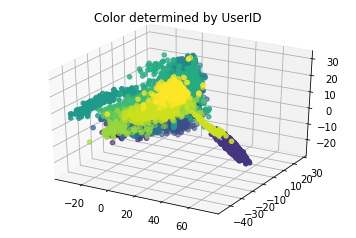

In [102]:
plot_manifold(manifold_3D, color = None)
plot_manifold(manifold_3D, color = 'Label')
plot_manifold(manifold_3D, color = 'UserID')

Here we select two users at random, and use $k=2$ clustering to try to separate them by user. Could also try for TapType, TaskName.

0.841698841699
0


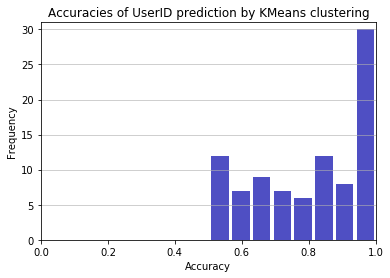

In [111]:
feature = 'UserID'
accuracies = []
for pair in all_possible_sublists(range(len(manifold_3D[feature].value_counts().index)), 2):
#= random.sample(range(len(manifold_3D[feature].value_counts().index)), 2)


    user_ids = []
    for user_label in pair:
        i = list(manifold_3D[feature].value_counts().index).index(user_label)
        user_ids.append(data[feature].value_counts().index[i])
    #print(feature,user_ids[0],'and',feature,user_ids[1])

    m = manifold_3D[(manifold_3D[feature] == pair[0]) | (manifold_3D[feature] == pair[1])]
    kmeans = cl.KMeans(n_clusters=2).fit(m)
    m['Label'] = kmeans.labels_ + 1
    m[feature] = pd.factorize(m[feature])[0] + 1
#     plot_manifold(m, color = 'Label')
#     plot_manifold(m, color = feature)
    m['Mix'] = 10 * m['Label'] + m[feature]

    max_sum = 0
    for a in [[11,22],[12,21]]: #[[11, 22, 33],[11, 23, 32],[12, 21, 33],[12, 23, 31],[13, 21, 32],[13, 22, 31]]:
        sum = len(m[(m.Mix == a[0]) | (m.Mix == a[1])])
        if sum > max_sum:
            max_sum = sum
    
    accuracies.append(max_sum / len(m))
#     print("Frequency of most common label:", max(m[feature].value_counts()[1], m[feature].value_counts()[2]) / len(m))
#     print("Success rate from guessing",feature,"by cluster:", max_sum / len(m))
m = mean(accuracies)
s = sd(accuracies)
print(m)
print(s)
n, bins, patches = plt.hist(x=accuracies, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracies of ' + feature + ' prediction by KMeans clustering')
maxfreq = n.max()
plt.xlim(xmin=0, xmax=1)
plt.ylim(ymax=maxfreq + 1)
plt.show()

In [166]:
m.head()

,Comp1,Comp2,Comp3,TapType,TaskName,UserID,Label
3848,7.451837,12.138655,6.929716,1,1,0,1
3849,7.232836,15.181128,3.999133,1,1,0,1
3850,12.581918,6.025253,0.153714,1,1,0,1
3851,13.951002,1.810787,2.750318,1,1,0,1
3852,17.291633,8.249932,3.743293,1,1,0,1


In [75]:
data.UserID.value_counts()

538363    3675
257279    3029
389015    2711
865501    1787
431312    1352
219303     760
264325     720
398248     622
897652     573
218719     466
180679     423
984799     414
579284     302
856302     221
Name: UserID, dtype: int64

In [108]:
data.SessionID.value_counts()

389015_session_20    2319
538363_session_21    1812
538363_session_18    1749
865501_session_10    1631
257279_session_13    1485
257279_session_11    1470
431312_session_14     974
219303_session_19     760
398248_session_21     622
897652_session_5      573
264325_session_7      554
218719_session_3      466
180679_session_21     423
984799_session_11     414
389015_session_11     342
579284_session_20     302
431312_session_2      224
856302_session_17     221
431312_session_9      154
865501_session_5      116
264325_session_8      115
538363_session_10     114
257279_session_17      74
264325_session_22      51
389015_session_24      50
865501_session_23      40
Name: SessionID, dtype: int64